Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
import pickle
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Choose the best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU (CUDA)")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS (Metal Performance Shaders)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Device selected:", device)


Using GPU (CUDA)
Device selected: cuda


In [5]:
# Paths
folder_path = r'D:\SeedLink\Agricultural-crops'
base_dir = r'D:\SeedLink\Agricultural-crops-split'

print(os.listdir(folder_path))
print(os.listdir(base_dir))


['Almond', 'Amaranth', 'Apple', 'Apricot', 'Arecanut', 'Asparagus', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Bell Pepper', 'Bitter Gourd', 'Black Berry', 'Black Current', 'Blueberry', 'Bottle Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Cardamom', 'Carrot', 'Cashew', 'Cauliflower', 'Cherry', 'Chikoo', 'Chilli', 'Clove', 'Coconut', 'Coffee-plant', 'Corn', 'Cotton', 'Cranberry', 'Cucumber', 'Custard Apple', 'Dates', 'Dragon Fruit', 'Elderberry', 'Fig', 'Fox_nut(Makhana)', 'Garlic', 'Ginger', 'Gooseberry', 'Gram', 'Grapes', 'Guava', 'Jackfruit', 'Jowar', 'Jute', 'Kiwi', 'Lemon', 'Lettuce', 'Litchi', 'Longan', 'Maize', 'Mango', 'Mushroom', 'Muskmelon', 'Mustard-oil', 'Okra', 'Olive', 'Onion', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pearl_millet(bajra)', 'Peas', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Pumpkin', 'Rice', 'Soyabean', 'Spinach', 'Strawberry', 'Sugarcane', 'Sunflower', 'Sweet Potato', 'Tamarind', 'Taro Roots', 'Tea', 'Tinda', 'Tobacco-plant', 'T

Load and preprocess dataset

In [6]:
# Create directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

for cls in classes:
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

In [7]:
train_dir = r'D:\SeedLink\Agricultural-crops-split\train'

for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    n = len(os.listdir(cls_path))
    print(cls, n)


Almond 19
Amaranth 7
Apple 564
Apricot 457
Arecanut 24
Asparagus 24
Avocado 210
Banana 27
Beans 922
Beetroot 77
Bell Pepper 1111
Bitter Gourd 917
Black Berry 1051
Black Current 925
Blueberry 429
Bottle Gourd 924
Brinjal 76
Broccoli 466
Cabbage 85
Capsicum 80
Cardamom 21
Carrot 537
Cashew 960
Cauliflower 538
Cherry 28
Chikoo 20
Chilli 19
Clove 29
Coconut 22
Coffee-plant 25
Corn 160
Cotton 29
Cranberry 946
Cucumber 28
Custard Apple 468
Dates 462
Dragon Fruit 459
Elderberry 938
Fig 944
Fox_nut(Makhana) 19
Garlic 552
Ginger 63
Gooseberry 972
Gram 24
Grapes 554
Guava 946
Jackfruit 464
Jowar 27
Jute 20
Kiwi 547
Lemon 24
Lettuce 90
Litchi 928
Longan 942
Maize 28
Mango 559
Mushroom 466
Muskmelon 796
Mustard-oil 27
Okra 484
Olive 953
Onion 554
Orange 539
Papaya 21
Passion Fruit 450
Peach 459
Pear 721
Pearl_millet(bajra) 37
Peas 91
Pineapple 23
Plum 415
Pomegranate 580
Potato 71
Pumpkin 924
Rice 26
Soyabean 28
Spinach 90
Strawberry 640
Sugarcane 21
Sunflower 20
Sweet Potato 522
Tamarind 29
Taro 

In [8]:
# Split with better ratios
split_ratio = {'train': 0.75, 'val': 0.15, 'test': 0.10}

for cls in classes:
    cls_path = os.path.join(folder_path, cls)
    if not os.path.isdir(cls_path):
        continue
    
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(n_total * split_ratio['train'])
    n_val = int(n_total * split_ratio['val'])
    
    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]
    
    for img in train_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, 'train', cls, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)
    
    for img in val_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, 'val', cls, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)
    
    for img in test_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, 'test', cls, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("Data splitting completed!")

Data splitting completed!


Enhanced data Augmentation

In [9]:
# Calculate ImageNet statistics for better normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Increased from 128
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Load Datasets with Class Balancing

In [10]:
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=val_test_transform)

# Calculate class weights for handling imbalanced data
class_counts = Counter(train_dataset.targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_dataset.targets]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders with weighted sampling
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Classes: {len(train_dataset.classes)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Classes: 95
Train: 33356, Val: 9932, Test: 8622


In [12]:
# Use pretrained ResNet50 for better feature extraction
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze early layers
for param in list(model.parameters())[:-20]:
    param.requires_grad = False

# Enhanced classifier with dropout
num_classes = len(train_dataset.classes)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

model = model.to(device)

Define Loss, Optimizer, and Scheduler

In [13]:
# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler - Cosine annealing with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# Early stopping
best_val_acc = 0
patience = 10
patience_counter = 0

Train Model

In [14]:
num_epochs = 50
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_train_acc = 100 * train_correct / train_total
    epoch_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_acc = 100 * val_correct / val_total
    epoch_val_loss = val_loss / len(val_loader)
    
    # Update scheduler
    scheduler.step()
    
    # Save metrics
    train_acc_history.append(epoch_train_acc)
    val_acc_history.append(epoch_val_acc)
    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)
    
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
    print(f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc,
        }, r'D:\SeedLink\best_model.pth')
        print(f'✓ New best model saved! Val Acc: {best_val_acc:.2f}%')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break


Epoch 1/50:   0%|          | 0/1043 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 1043/1043 [03:47<00:00,  4.59it/s, loss=1.7986]



Epoch [1/50]
Train Loss: 2.5071 | Train Acc: 48.37%
Val Loss: 1.8306 | Val Acc: 73.25%
Learning Rate: 0.000976
✓ New best model saved! Val Acc: 73.25%


Epoch 2/50: 100%|██████████| 1043/1043 [05:10<00:00,  3.36it/s, loss=1.8861]



Epoch [2/50]
Train Loss: 1.7235 | Train Acc: 73.76%
Val Loss: 1.5031 | Val Acc: 82.40%
Learning Rate: 0.000905
✓ New best model saved! Val Acc: 82.40%


Epoch 3/50: 100%|██████████| 1043/1043 [07:45<00:00,  2.24it/s, loss=1.3612]



Epoch [3/50]
Train Loss: 1.4808 | Train Acc: 81.90%
Val Loss: 1.3581 | Val Acc: 85.18%
Learning Rate: 0.000794
✓ New best model saved! Val Acc: 85.18%


Epoch 4/50: 100%|██████████| 1043/1043 [05:53<00:00,  2.95it/s, loss=1.8049]



Epoch [4/50]
Train Loss: 1.3633 | Train Acc: 85.84%
Val Loss: 1.2839 | Val Acc: 88.37%
Learning Rate: 0.000655
✓ New best model saved! Val Acc: 88.37%


Epoch 5/50: 100%|██████████| 1043/1043 [07:11<00:00,  2.42it/s, loss=1.1914]



Epoch [5/50]
Train Loss: 1.2594 | Train Acc: 88.87%
Val Loss: 1.1779 | Val Acc: 90.68%
Learning Rate: 0.000501
✓ New best model saved! Val Acc: 90.68%


Epoch 6/50: 100%|██████████| 1043/1043 [06:08<00:00,  2.83it/s, loss=1.2880]



Epoch [6/50]
Train Loss: 1.1857 | Train Acc: 90.98%
Val Loss: 1.1177 | Val Acc: 92.23%
Learning Rate: 0.000346
✓ New best model saved! Val Acc: 92.23%


Epoch 7/50: 100%|██████████| 1043/1043 [06:04<00:00,  2.86it/s, loss=1.0799]



Epoch [7/50]
Train Loss: 1.1297 | Train Acc: 92.59%
Val Loss: 1.0553 | Val Acc: 93.29%
Learning Rate: 0.000207
✓ New best model saved! Val Acc: 93.29%


Epoch 8/50: 100%|██████████| 1043/1043 [06:48<00:00,  2.56it/s, loss=0.9758]



Epoch [8/50]
Train Loss: 1.0895 | Train Acc: 93.63%
Val Loss: 1.0471 | Val Acc: 93.54%
Learning Rate: 0.000096
✓ New best model saved! Val Acc: 93.54%


Epoch 9/50: 100%|██████████| 1043/1043 [05:56<00:00,  2.92it/s, loss=1.3908]



Epoch [9/50]
Train Loss: 1.0523 | Train Acc: 94.56%
Val Loss: 1.0093 | Val Acc: 94.76%
Learning Rate: 0.000025
✓ New best model saved! Val Acc: 94.76%


Epoch 10/50: 100%|██████████| 1043/1043 [06:17<00:00,  2.76it/s, loss=1.0260]



Epoch [10/50]
Train Loss: 1.0360 | Train Acc: 95.01%
Val Loss: 0.9967 | Val Acc: 94.78%
Learning Rate: 0.001000
✓ New best model saved! Val Acc: 94.78%


Epoch 11/50: 100%|██████████| 1043/1043 [05:55<00:00,  2.94it/s, loss=1.6310]



Epoch [11/50]
Train Loss: 1.2817 | Train Acc: 88.57%
Val Loss: 1.2616 | Val Acc: 90.40%
Learning Rate: 0.000994


Epoch 12/50: 100%|██████████| 1043/1043 [06:00<00:00,  2.89it/s, loss=1.8665]



Epoch [12/50]
Train Loss: 1.2119 | Train Acc: 90.58%
Val Loss: 1.1739 | Val Acc: 90.78%
Learning Rate: 0.000976


Epoch 13/50: 100%|██████████| 1043/1043 [06:19<00:00,  2.75it/s, loss=1.1378]



Epoch [13/50]
Train Loss: 1.1753 | Train Acc: 91.35%
Val Loss: 1.1219 | Val Acc: 91.93%
Learning Rate: 0.000946


Epoch 14/50: 100%|██████████| 1043/1043 [06:11<00:00,  2.81it/s, loss=1.0797]



Epoch [14/50]
Train Loss: 1.1371 | Train Acc: 92.47%
Val Loss: 1.0746 | Val Acc: 93.02%
Learning Rate: 0.000905


Epoch 15/50: 100%|██████████| 1043/1043 [06:27<00:00,  2.69it/s, loss=1.4984]



Epoch [15/50]
Train Loss: 1.1188 | Train Acc: 92.92%
Val Loss: 1.0516 | Val Acc: 93.61%
Learning Rate: 0.000854


Epoch 16/50: 100%|██████████| 1043/1043 [08:39<00:00,  2.01it/s, loss=1.3702]



Epoch [16/50]
Train Loss: 1.0896 | Train Acc: 93.63%
Val Loss: 1.0671 | Val Acc: 92.73%
Learning Rate: 0.000794


Epoch 17/50: 100%|██████████| 1043/1043 [06:04<00:00,  2.86it/s, loss=1.0683]



Epoch [17/50]
Train Loss: 1.0677 | Train Acc: 94.10%
Val Loss: 1.0121 | Val Acc: 94.52%
Learning Rate: 0.000727


Epoch 18/50: 100%|██████████| 1043/1043 [06:03<00:00,  2.87it/s, loss=0.8751]



Epoch [18/50]
Train Loss: 1.0429 | Train Acc: 94.89%
Val Loss: 1.0330 | Val Acc: 93.30%
Learning Rate: 0.000655


Epoch 19/50: 100%|██████████| 1043/1043 [06:05<00:00,  2.85it/s, loss=1.2052]



Epoch [19/50]
Train Loss: 1.0259 | Train Acc: 95.14%
Val Loss: 0.9905 | Val Acc: 94.83%
Learning Rate: 0.000579
✓ New best model saved! Val Acc: 94.83%


Epoch 20/50: 100%|██████████| 1043/1043 [07:13<00:00,  2.41it/s, loss=0.9557]



Epoch [20/50]
Train Loss: 1.0050 | Train Acc: 95.68%
Val Loss: 0.9891 | Val Acc: 95.38%
Learning Rate: 0.000501
✓ New best model saved! Val Acc: 95.38%


Epoch 21/50: 100%|██████████| 1043/1043 [07:42<00:00,  2.26it/s, loss=0.9322]



Epoch [21/50]
Train Loss: 0.9868 | Train Acc: 95.98%
Val Loss: 0.9589 | Val Acc: 95.57%
Learning Rate: 0.000422
✓ New best model saved! Val Acc: 95.57%


Epoch 22/50: 100%|██████████| 1043/1043 [07:24<00:00,  2.35it/s, loss=0.8728]



Epoch [22/50]
Train Loss: 0.9750 | Train Acc: 96.27%
Val Loss: 0.9493 | Val Acc: 95.90%
Learning Rate: 0.000346
✓ New best model saved! Val Acc: 95.90%


Epoch 23/50: 100%|██████████| 1043/1043 [06:06<00:00,  2.84it/s, loss=0.9790]



Epoch [23/50]
Train Loss: 0.9561 | Train Acc: 96.86%
Val Loss: 0.9415 | Val Acc: 96.00%
Learning Rate: 0.000274
✓ New best model saved! Val Acc: 96.00%


Epoch 24/50: 100%|██████████| 1043/1043 [08:07<00:00,  2.14it/s, loss=0.9289]



Epoch [24/50]
Train Loss: 0.9451 | Train Acc: 97.12%
Val Loss: 0.9185 | Val Acc: 96.43%
Learning Rate: 0.000207
✓ New best model saved! Val Acc: 96.43%


Epoch 25/50: 100%|██████████| 1043/1043 [06:43<00:00,  2.59it/s, loss=1.0064]



Epoch [25/50]
Train Loss: 0.9325 | Train Acc: 97.48%
Val Loss: 0.9003 | Val Acc: 97.14%
Learning Rate: 0.000147
✓ New best model saved! Val Acc: 97.14%


Epoch 26/50: 100%|██████████| 1043/1043 [06:26<00:00,  2.70it/s, loss=0.9432]



Epoch [26/50]
Train Loss: 0.9217 | Train Acc: 97.72%
Val Loss: 0.9092 | Val Acc: 96.93%
Learning Rate: 0.000096


Epoch 27/50: 100%|██████████| 1043/1043 [06:20<00:00,  2.74it/s, loss=0.8266]



Epoch [27/50]
Train Loss: 0.9236 | Train Acc: 97.57%
Val Loss: 0.8884 | Val Acc: 97.33%
Learning Rate: 0.000055
✓ New best model saved! Val Acc: 97.33%


Epoch 28/50: 100%|██████████| 1043/1043 [06:02<00:00,  2.88it/s, loss=1.2056]



Epoch [28/50]
Train Loss: 0.9150 | Train Acc: 97.75%
Val Loss: 0.8890 | Val Acc: 97.29%
Learning Rate: 0.000025


Epoch 29/50: 100%|██████████| 1043/1043 [06:05<00:00,  2.85it/s, loss=0.9278]



Epoch [29/50]
Train Loss: 0.9123 | Train Acc: 97.86%
Val Loss: 0.8838 | Val Acc: 97.38%
Learning Rate: 0.000007
✓ New best model saved! Val Acc: 97.38%


Epoch 30/50: 100%|██████████| 1043/1043 [06:18<00:00,  2.76it/s, loss=1.2335]



Epoch [30/50]
Train Loss: 0.9146 | Train Acc: 97.83%
Val Loss: 0.8867 | Val Acc: 97.46%
Learning Rate: 0.001000
✓ New best model saved! Val Acc: 97.46%


Epoch 31/50: 100%|██████████| 1043/1043 [06:15<00:00,  2.78it/s, loss=0.9890]



Epoch [31/50]
Train Loss: 1.0455 | Train Acc: 94.53%
Val Loss: 0.9834 | Val Acc: 95.00%
Learning Rate: 0.000998


Epoch 32/50: 100%|██████████| 1043/1043 [06:11<00:00,  2.80it/s, loss=0.9670]



Epoch [32/50]
Train Loss: 1.0235 | Train Acc: 95.10%
Val Loss: 1.0037 | Val Acc: 94.66%
Learning Rate: 0.000994


Epoch 33/50: 100%|██████████| 1043/1043 [06:08<00:00,  2.83it/s, loss=1.0611]



Epoch [33/50]
Train Loss: 1.0200 | Train Acc: 95.07%
Val Loss: 0.9759 | Val Acc: 95.61%
Learning Rate: 0.000986


Epoch 34/50: 100%|██████████| 1043/1043 [06:00<00:00,  2.89it/s, loss=0.8829]



Epoch [34/50]
Train Loss: 1.0102 | Train Acc: 95.41%
Val Loss: 0.9669 | Val Acc: 95.99%
Learning Rate: 0.000976


Epoch 35/50: 100%|██████████| 1043/1043 [06:06<00:00,  2.85it/s, loss=0.9714]



Epoch [35/50]
Train Loss: 0.9951 | Train Acc: 95.79%
Val Loss: 0.9551 | Val Acc: 95.72%
Learning Rate: 0.000962


Epoch 36/50: 100%|██████████| 1043/1043 [06:10<00:00,  2.81it/s, loss=0.8345]



Epoch [36/50]
Train Loss: 0.9907 | Train Acc: 95.87%
Val Loss: 0.9626 | Val Acc: 95.56%
Learning Rate: 0.000946


Epoch 37/50: 100%|██████████| 1043/1043 [06:21<00:00,  2.73it/s, loss=1.2451]



Epoch [37/50]
Train Loss: 0.9787 | Train Acc: 96.05%
Val Loss: 0.9593 | Val Acc: 95.67%
Learning Rate: 0.000926


Epoch 38/50: 100%|██████████| 1043/1043 [06:43<00:00,  2.59it/s, loss=0.8831]



Epoch [38/50]
Train Loss: 0.9690 | Train Acc: 96.34%
Val Loss: 0.9483 | Val Acc: 96.20%
Learning Rate: 0.000905


Epoch 39/50: 100%|██████████| 1043/1043 [07:28<00:00,  2.33it/s, loss=0.8586]



Epoch [39/50]
Train Loss: 0.9683 | Train Acc: 96.32%
Val Loss: 0.9405 | Val Acc: 95.94%
Learning Rate: 0.000880


Epoch 40/50: 100%|██████████| 1043/1043 [08:54<00:00,  1.95it/s, loss=0.9628]



Epoch [40/50]
Train Loss: 0.9616 | Train Acc: 96.46%
Val Loss: 0.9343 | Val Acc: 96.10%
Learning Rate: 0.000854

Early stopping triggered after 40 epochs


In [16]:
checkpoint = torch.load(r'D:\SeedLink\best_model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Test evaluation
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'\n{"="*50}')
print(f'Final Test Accuracy: {test_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
print(f'{"="*50}')

# Save final model and classes
torch.save(model.state_dict(), r'D:\SeedLink\agri_crop_model_final.pth')
with open(r'D:\SeedLink\classes.pkl', 'wb') as f:
    pickle.dump(train_dataset.classes, f)


Final Test Accuracy: 97.22%
Best Validation Accuracy: 97.46%


Visualization

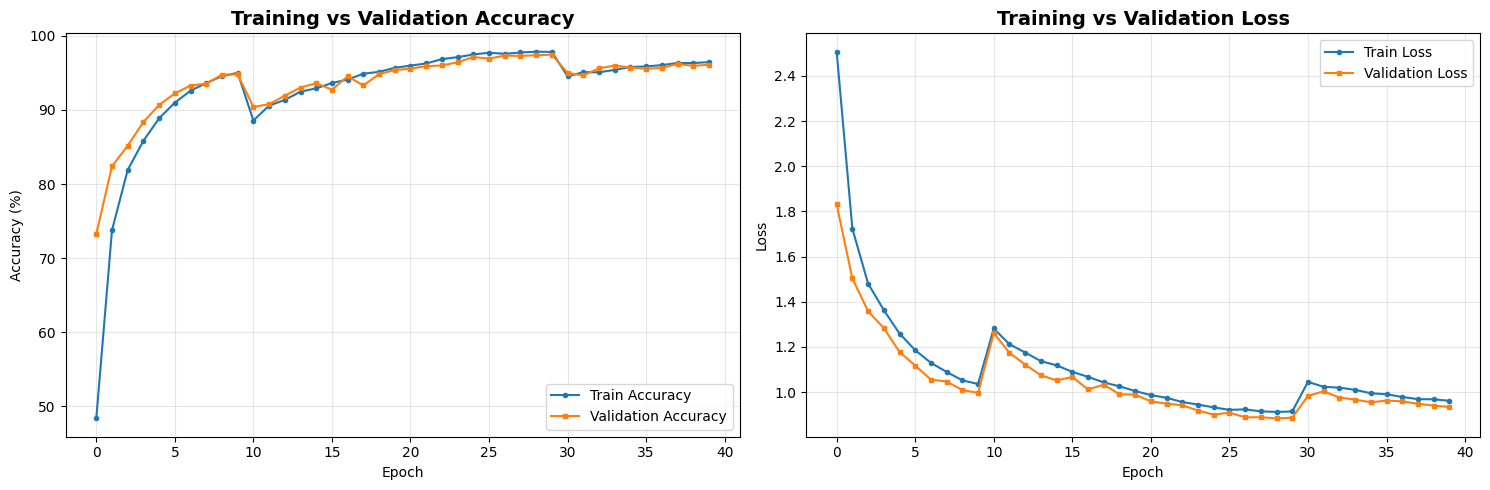

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(train_acc_history, label='Train Accuracy', marker='o', markersize=3)
axes[0].plot(val_acc_history, label='Validation Accuracy', marker='s', markersize=3)
axes[0].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(train_loss_history, label='Train Loss', marker='o', markersize=3)
axes[1].plot(val_loss_history, label='Validation Loss', marker='s', markersize=3)
axes[1].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'D:\SeedLink\training_history.png', dpi=300, bbox_inches='tight')
plt.show()


Comprehensive Evaluation

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, dataset_name="Test"):
    """Comprehensive model evaluation"""
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    print(f"\n{'='*60}")
    print(f"Evaluating on {dataset_name} Set...")
    print(f"{'='*60}")
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f'{dataset_name} Evaluation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    print(f"\n{dataset_name} Results:")
    print(f"{'─'*60}")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")
    
    return all_preds, all_labels, all_probs, avg_loss, accuracy

# Evaluate on all datasets
train_preds, train_labels, train_probs, train_loss_final, train_acc_final = evaluate_model(model, train_loader, "Train")
val_preds, val_labels, val_probs, val_loss_final, val_acc_final = evaluate_model(model, val_loader, "Validation")
test_preds, test_labels, test_probs, test_loss_final, test_acc_final = evaluate_model(model, test_loader, "Test")


Evaluating on Train Set...


Train Evaluation: 100%|██████████| 1043/1043 [05:40<00:00,  3.07it/s]



Train Results:
────────────────────────────────────────────────────────────
Average Loss: 0.8391
Accuracy: 98.65% (32907/33356)

Evaluating on Validation Set...


Validation Evaluation: 100%|██████████| 311/311 [01:45<00:00,  2.95it/s]



Validation Results:
────────────────────────────────────────────────────────────
Average Loss: 0.8867
Accuracy: 97.46% (9680/9932)

Evaluating on Test Set...


Test Evaluation: 100%|██████████| 270/270 [01:13<00:00,  3.67it/s]


Test Results:
────────────────────────────────────────────────────────────
Average Loss: 0.8903
Accuracy: 97.22% (8382/8622)


Detailed Classification Report

In [22]:
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}\n")

# Classification report for test set
print("Test Set Classification Report:")
print("─"*60)
report = classification_report(
    test_labels, 
    test_preds, 
    target_names=train_dataset.classes,
    digits=4
)
print(report)

# Save classification report
with open(r'D:\SeedLink\classification_report.txt', 'w') as f:
    f.write(f"Model Evaluation Report\n")
    f.write(f"{'='*60}\n\n")
    f.write(f"Train Accuracy: {train_acc_final:.2f}%\n")
    f.write(f"Validation Accuracy: {val_acc_final:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc_final:.2f}%\n\n")
    f.write(f"Train Loss: {train_loss_final:.4f}\n")
    f.write(f"Validation Loss: {val_loss_final:.4f}\n")
    f.write(f"Test Loss: {test_loss_final:.4f}\n\n")
    f.write("-"*60 + "\n")
    f.write("Test Set Classification Report:\n")
    f.write("-"*60 + "\n")
    f.write(report)

print("\n✓ Classification report saved to 'classification_report.txt'")


DETAILED CLASSIFICATION REPORT

Test Set Classification Report:
────────────────────────────────────────────────────────────
                     precision    recall  f1-score   support

             Almond     1.0000    1.0000    1.0000         7
           Amaranth     1.0000    0.6667    0.8000         3
              Apple     0.9793    0.9726    0.9759       146
            Apricot     1.0000    1.0000    1.0000       116
           Arecanut     0.8571    0.8571    0.8571         7
          Asparagus     1.0000    1.0000    1.0000         7
            Avocado     1.0000    0.9828    0.9913        58
             Banana     1.0000    0.8889    0.9412         9
              Beans     0.9957    1.0000    0.9979       234
           Beetroot     1.0000    0.9000    0.9474        20
        Bell Pepper     1.0000    0.9187    0.9576       283
       Bitter Gourd     1.0000    0.9958    0.9979       240
        Black Berry     0.9741    0.9850    0.9795       267
      Black Current

Pre-Class Accuracy Analysis

In [23]:
print(f"\n{'='*60}")
print("PER-CLASS ACCURACY ANALYSIS")
print(f"{'='*60}\n")

# Calculate per-class accuracy
class_correct = {}
class_total = {}

for label, pred in zip(test_labels, test_preds):
    class_name = train_dataset.classes[label]
    if class_name not in class_total:
        class_total[class_name] = 0
        class_correct[class_name] = 0
    class_total[class_name] += 1
    if label == pred:
        class_correct[class_name] += 1

# Sort by accuracy
class_accuracies = {cls: (class_correct[cls] / class_total[cls]) * 100 
                    for cls in class_total.keys()}
sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

# Display top and bottom performers
print("Top 10 Best Performing Classes:")
print("─"*60)
for i, (cls, acc) in enumerate(sorted_accuracies[:10], 1):
    print(f"{i:2d}. {cls:25s} - {acc:6.2f}% ({class_correct[cls]}/{class_total[cls]})")

print(f"\n{'─'*60}")
print("Bottom 10 Worst Performing Classes:")
print("─"*60)
for i, (cls, acc) in enumerate(sorted_accuracies[-10:], 1):
    print(f"{i:2d}. {cls:25s} - {acc:6.2f}% ({class_correct[cls]}/{class_total[cls]})")


PER-CLASS ACCURACY ANALYSIS

Top 10 Best Performing Classes:
────────────────────────────────────────────────────────────
 1. Almond                    - 100.00% (7/7)
 2. Apricot                   - 100.00% (116/116)
 3. Asparagus                 - 100.00% (7/7)
 4. Beans                     - 100.00% (234/234)
 5. Blueberry                 - 100.00% (108/108)
 6. Bottle Gourd              - 100.00% (235/235)
 7. Cabbage                   - 100.00% (23/23)
 8. Cardamom                  - 100.00% (6/6)
 9. Cherry                    - 100.00% (10/10)
10. Chikoo                    - 100.00% (6/6)

────────────────────────────────────────────────────────────
Bottom 10 Worst Performing Classes:
────────────────────────────────────────────────────────────
 1. Sugarcane                 -  87.50% (7/8)
 2. Gooseberry                -  87.40% (215/246)
 3. Arecanut                  -  85.71% (6/7)
 4. Lemon                     -  85.71% (6/7)
 5. Taro Roots                -  85.71% (6/7)
 6. 

Confusion Matrix Visualization

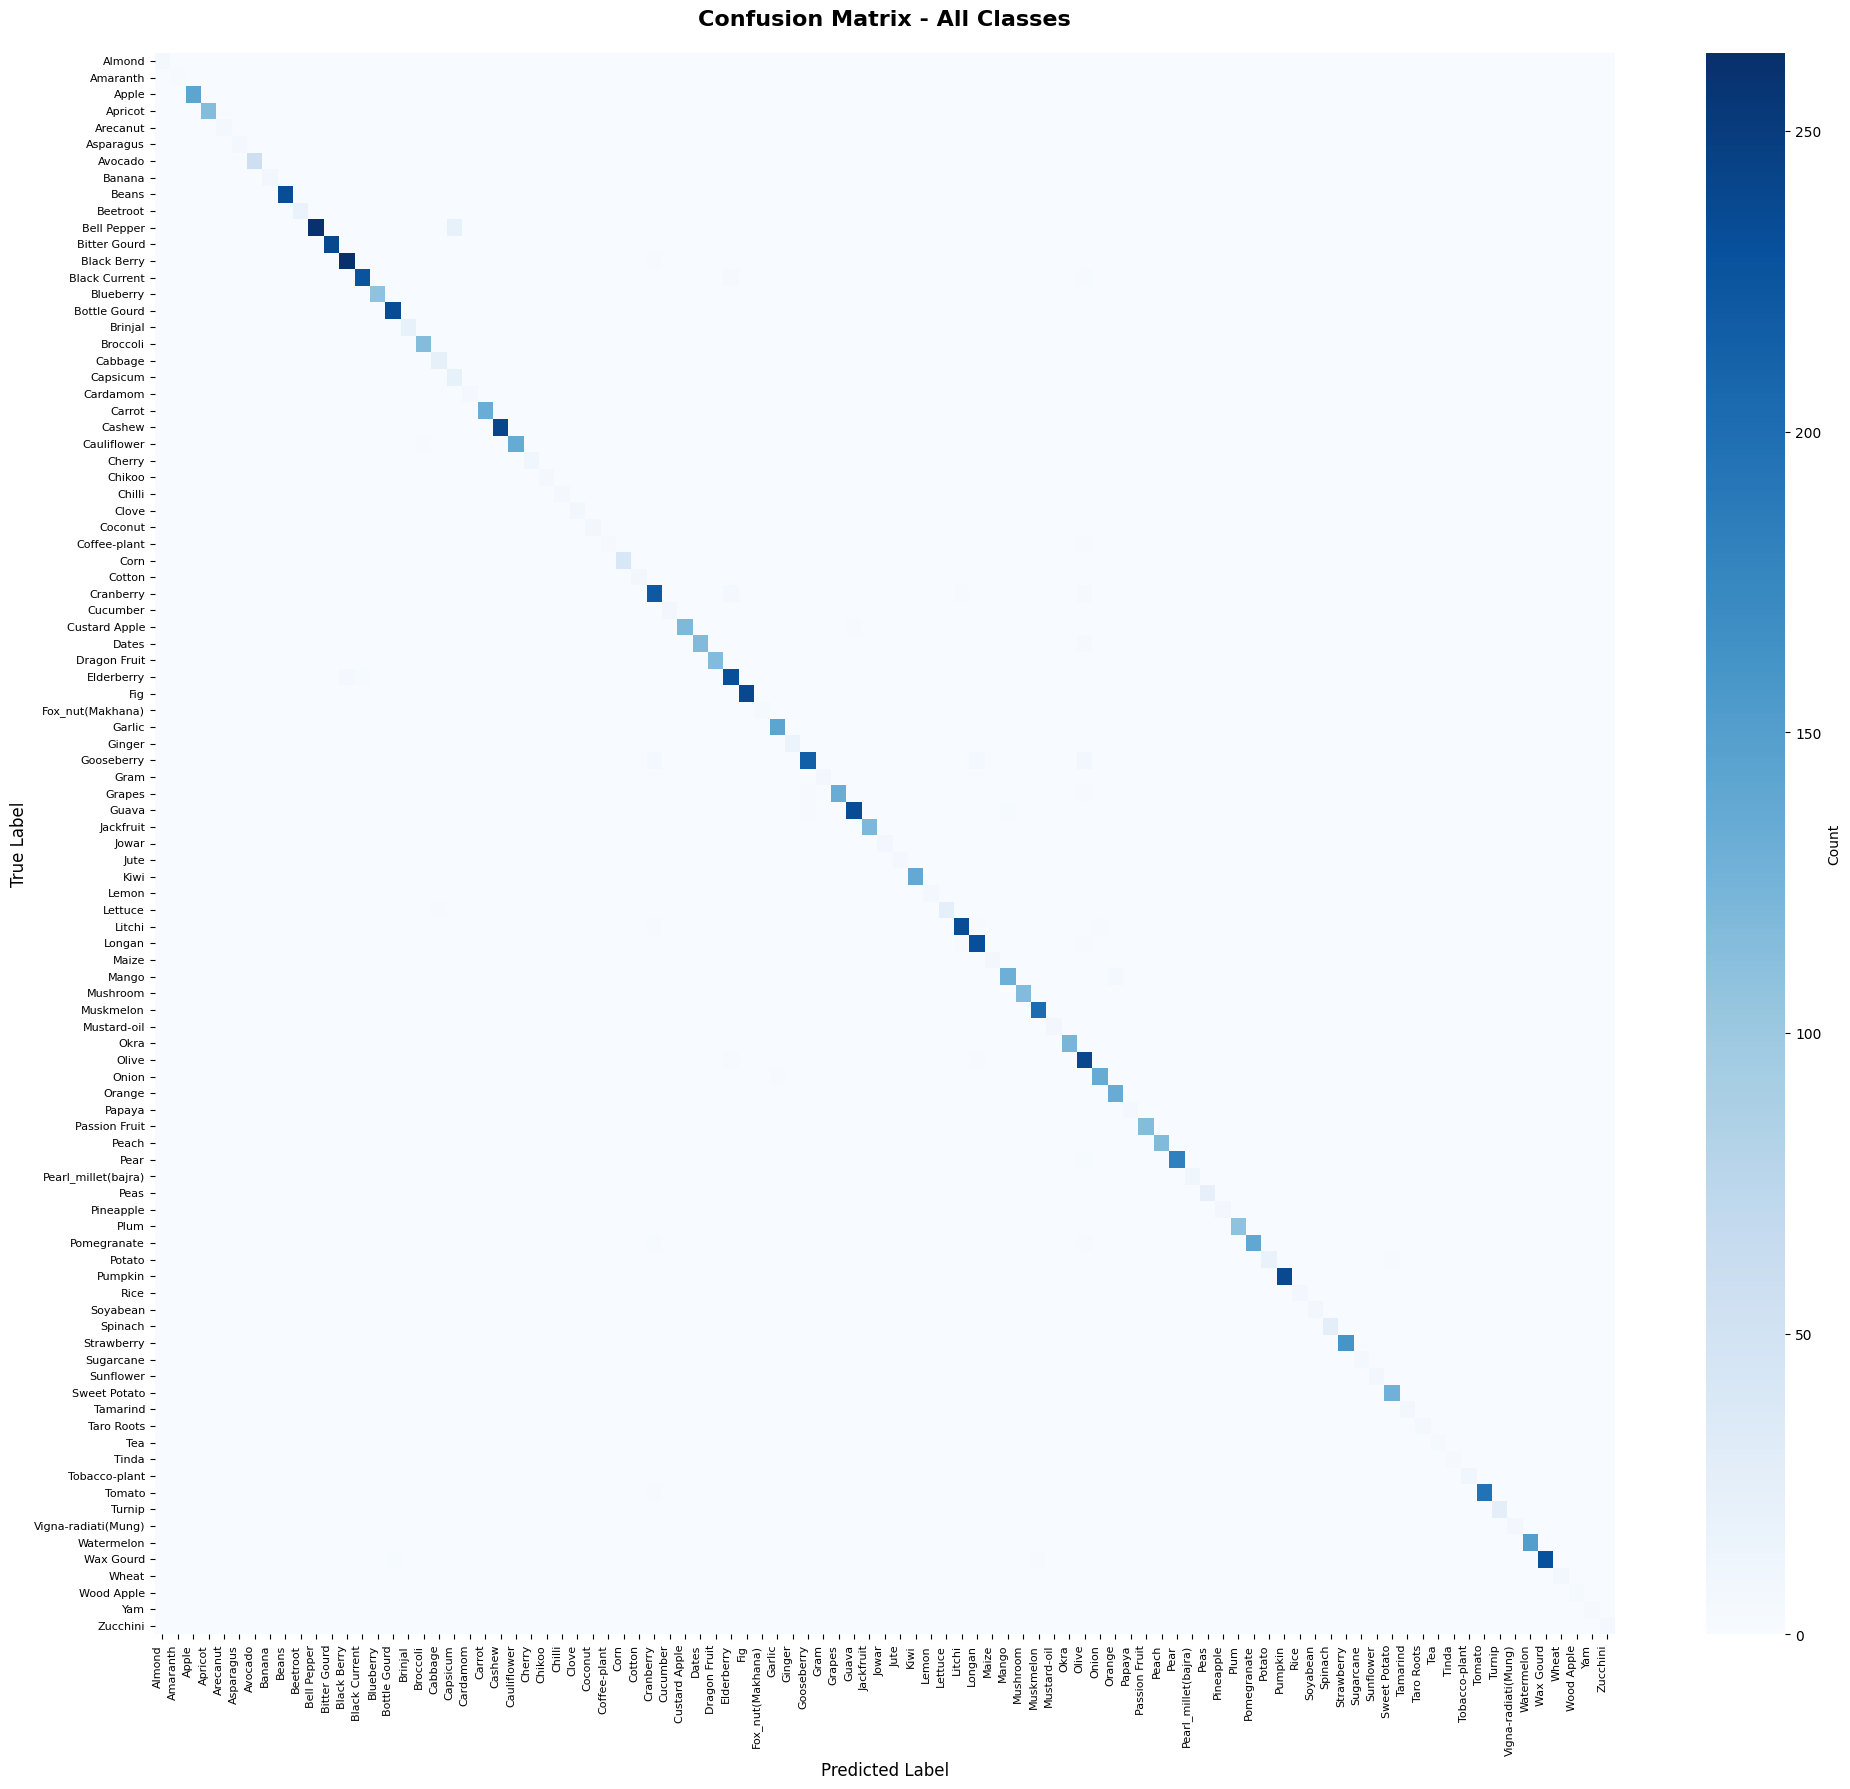

✓ Full confusion matrix saved to 'confusion_matrix_full.png'


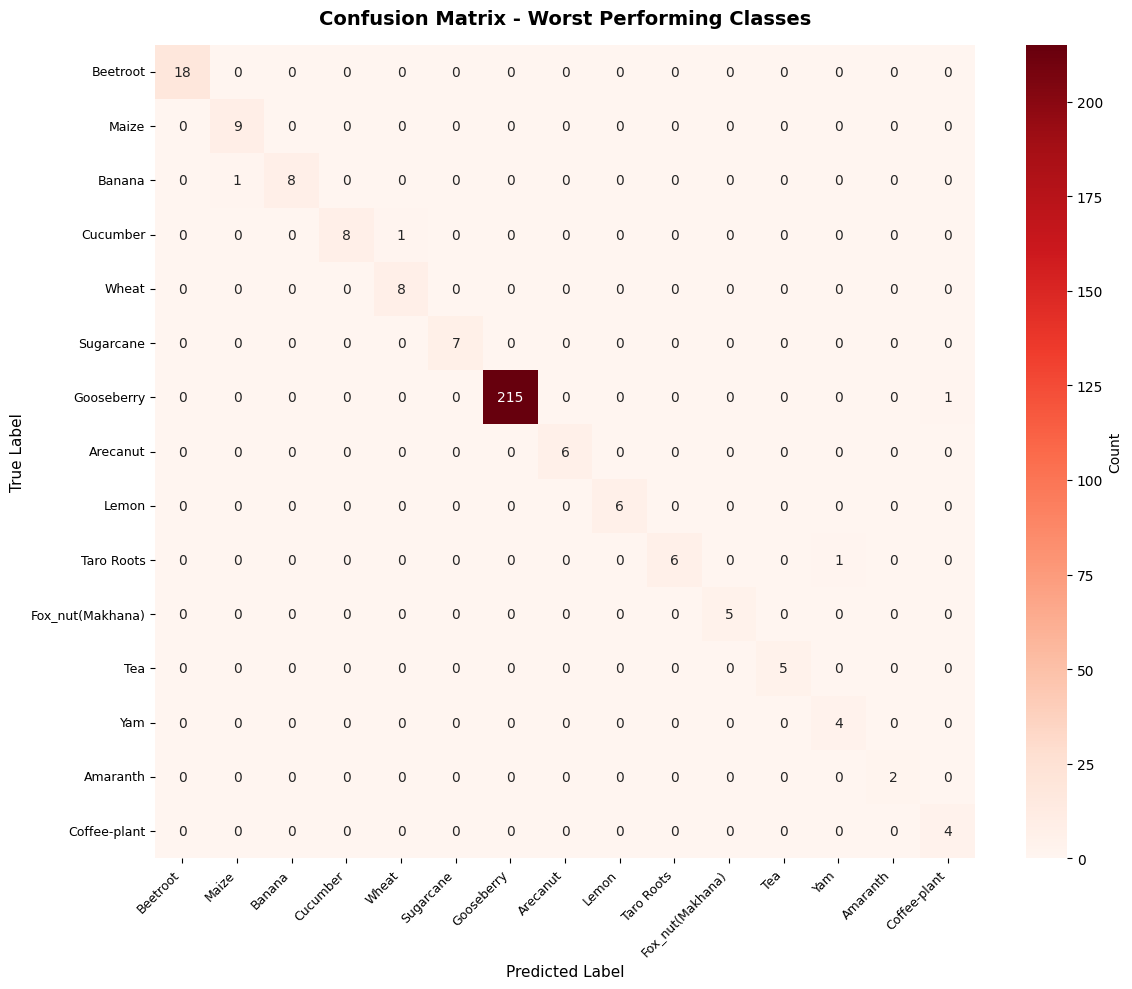

✓ Worst classes confusion matrix saved to 'confusion_matrix_worst.png'


In [24]:
# Create confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix (for subset of classes due to size)
plt.figure(figsize=(20, 18))

# Show full confusion matrix
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - All Classes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(r'D:\SeedLink\confusion_matrix_full.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Full confusion matrix saved to 'confusion_matrix_full.png'")

# Plot confusion matrix for worst performing classes
worst_classes = [cls for cls, _ in sorted_accuracies[-15:]]
worst_indices = [train_dataset.classes.index(cls) for cls in worst_classes]

# Filter confusion matrix
cm_subset = cm[np.ix_(worst_indices, worst_indices)]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Reds',
            xticklabels=worst_classes,
            yticklabels=worst_classes,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Worst Performing Classes', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(r'D:\SeedLink\confusion_matrix_worst.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Worst classes confusion matrix saved to 'confusion_matrix_worst.png'")

Loss and Accuracy Summary

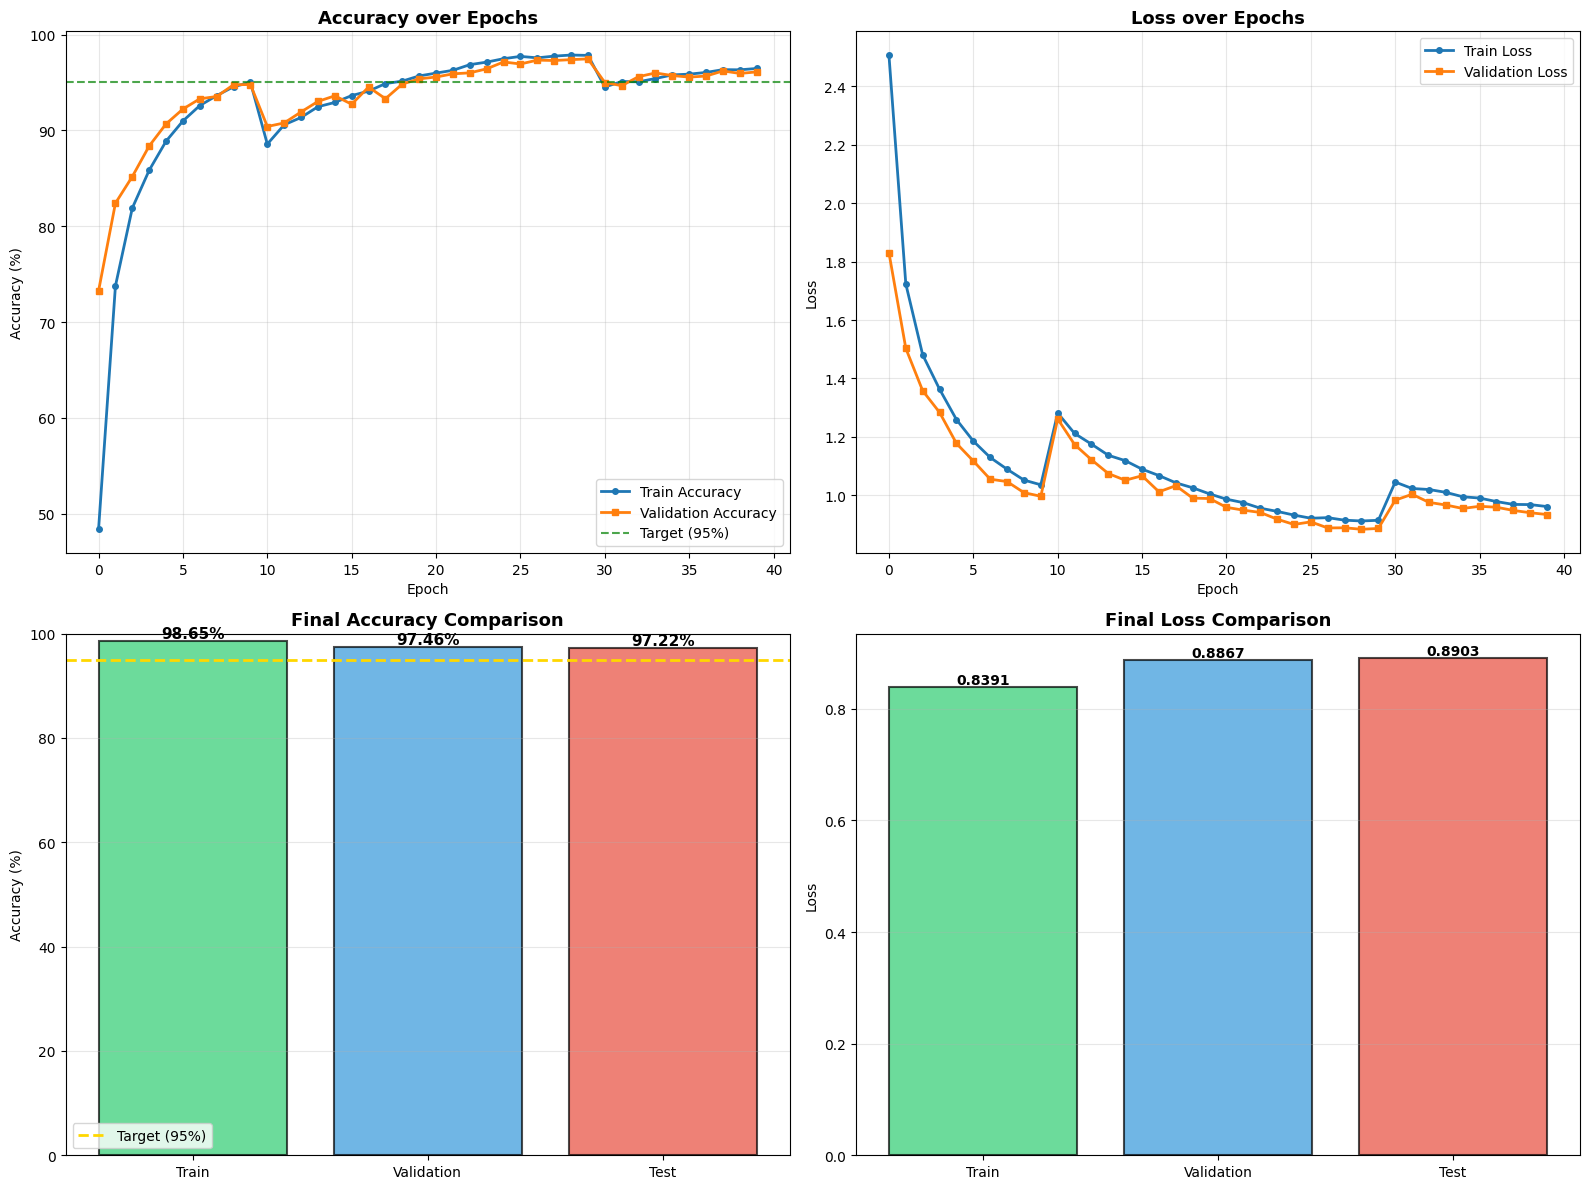


✓ Evaluation summary saved to 'final_evaluation_summary.png'


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training/Validation curves
axes[0, 0].plot(train_acc_history, label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(val_acc_history, label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[0, 0].axhline(y=95, color='g', linestyle='--', label='Target (95%)', alpha=0.7)
axes[0, 0].set_title('Accuracy over Epochs', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(train_loss_history, label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(val_loss_history, label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_title('Loss over Epochs', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Final comparison bar chart
datasets = ['Train', 'Validation', 'Test']
accuracies = [train_acc_final, val_acc_final, test_acc_final]
losses = [train_loss_final, val_loss_final, test_loss_final]

colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = axes[1, 0].bar(datasets, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].axhline(y=95, color='gold', linestyle='--', linewidth=2, label='Target (95%)')
axes[1, 0].set_title('Final Accuracy Comparison', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

bars2 = axes[1, 1].bar(datasets, losses, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('Final Loss Comparison', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, loss in zip(bars2, losses):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{loss:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(r'D:\SeedLink\final_evaluation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation summary saved to 'final_evaluation_summary.png'")



Model Performance Summary

In [29]:
print(f"\n{'='*70}")
print(f"{'FINAL MODEL PERFORMANCE SUMMARY':^70}")
print(f"{'='*70}\n")

summary_data = [
    ["Dataset", "Accuracy (%)", "Loss", "Samples"],
    ["─"*15, "─"*15, "─"*15, "─"*15],
    ["Train", f"{train_acc_final:.2f}%", f"{train_loss_final:.4f}", len(train_dataset)],
    ["Validation", f"{val_acc_final:.2f}%", f"{val_loss_final:.4f}", len(val_dataset)],
    ["Test", f"{test_acc_final:.2f}%", f"{test_loss_final:.4f}", len(test_dataset)],
]

# Print header
print(f"{summary_data[0][0]:20s} {summary_data[0][1]:>15s} {summary_data[0][2]:>15s} {summary_data[0][3]:>15s}")
print(f"{'─'*70}")

# Print table rows (skip headers and divider)
for row in summary_data[2:]:
    print(f"{row[0]:20s} {row[1]:>15} {row[2]:>15} {row[3]:>15d}")

print(f"\n{'─'*70}")
print(f"Number of Classes: {num_classes}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Model Architecture: ResNet50 (Pretrained)")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"{'='*70}\n")

# 🎯 Target achievement check
if test_acc_final >= 95.0:
    print("🎉 CONGRATULATIONS! Target accuracy of more than 95% achieved!")
else:
    print(f"⚠️  Current accuracy: {test_acc_final:.2f}%. Target: 95.0%")
    print("   Consider: longer training, data augmentation, or trying EfficientNet")



                   FINAL MODEL PERFORMANCE SUMMARY                    

Dataset                 Accuracy (%)            Loss         Samples
──────────────────────────────────────────────────────────────────────
Train                         98.65%          0.8391           33356
Validation                    97.46%          0.8867            9932
Test                          97.22%          0.8903            8622

──────────────────────────────────────────────────────────────────────
Number of Classes: 95
Best Validation Accuracy: 97.46%
Model Architecture: ResNet50 (Pretrained)
Total Parameters: 24,605,855
Trainable Parameters: 10,023,007

🎉 CONGRATULATIONS! Target accuracy of more than 95% achieved!


Inference Function

In [32]:
def predict_crop(image_path, threshold=0.75):
    """Predict crop with confidence threshold"""
    image = Image.open(image_path).convert('RGB')
    image_tensor = val_test_transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        max_prob, pred = torch.max(probs, 1)
        
        # Get top 3 predictions
        top3_probs, top3_indices = torch.topk(probs, 3)
        
        if max_prob.item() >= threshold:
            crop_name = train_dataset.classes[pred.item()]
            print(f"\n🌿 Predicted: {crop_name}")
            print(f"   Confidence: {max_prob.item():.2%}\n")
            print("Top 3 Predictions:")
            for i in range(3):
                cls_name = train_dataset.classes[top3_indices[0][i]]
                prob = top3_probs[0][i].item()
                print(f"   {i+1}. {cls_name:20s} - {prob:.2%}")
            return crop_name, max_prob.item()
        else:
            print(f"\n❓ Low Confidence Prediction")
            print(f"   Best guess: {train_dataset.classes[pred.item()]}")
            print(f"   Confidence: {max_prob.item():.2%}")
            print("   This may be an unknown crop or unclear image.\n")
            return "Unknown/Low Confidence", max_prob.item()

# Test inference
test_image = r'D:\SeedLink\Agricultural-crops\Cherry\image15.jpeg'
crop, confidence = predict_crop(test_image)


🌿 Predicted: Cherry
   Confidence: 94.19%

Top 3 Predictions:
   1. Cherry               - 94.19%
   2. Cranberry            - 0.12%
   3. Bitter Gourd         - 0.12%
